<a href="https://colab.research.google.com/github/satoruk-icepp/mlhep2019_2_phase/blob/master/analysis/Bayesian_lhcb_calo_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
! wget https://raw.githubusercontent.com/SchattenGenie/mlhep2019_2_phase/master/analysis/calogan_metrics.py -nc
! wget https://raw.githubusercontent.com/SchattenGenie/mlhep2019_2_phase/master/analysis/prd_score.py -nc
! wget https://raw.githubusercontent.com/SchattenGenie/mlhep2019_2_phase/master/analysis/score.py -nc
! wget https://github.com/SchattenGenie/mlhep2019_2_phase/raw/master/analysis/embedder.tp -nc
! wget https://github.com/satoruk-icepp/mlhep2019_2_phase/raw/master/analysis/generator.py

File ‘calogan_metrics.py’ already there; not retrieving.

File ‘prd_score.py’ already there; not retrieving.

File ‘score.py’ already there; not retrieving.

File ‘embedder.tp’ already there; not retrieving.

--2019-07-26 00:20:17--  https://github.com/satoruk-icepp/mlhep2019_2_phase/raw/master/analysis/generator.py
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/satoruk-icepp/mlhep2019_2_phase/master/analysis/generator.py [following]
--2019-07-26 00:20:18--  https://raw.githubusercontent.com/satoruk-icepp/mlhep2019_2_phase/master/analysis/generator.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 

In [0]:
%%writefile .comet.config
[comet]
api_key=mIel5ZAPOioTs0Cij75dSSQXs
logging_file = /tmp/comet.log
logging_file_level = info


Overwriting .comet.config


In [0]:
! [ ! -z "$COLAB_GPU" ] && pip install skorch comet_ml

In [0]:
from comet_ml import Experiment
experiment = Experiment(project_name="BayesGAN")

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/satoruk-icepp/bayesgan/062e60f21fc94c08b64946c626060193



In [0]:
BATCH_SIZE         = 150
N_EPOCH            = 200

learning_rate      = 0.00005
dnoise_alpha       = 0.001
gnoise_alpha       = 0.001
N=50250
NOISE_DIM = 100
Ngen = 1
Ndisc = 1
EnergyDepositScale = 4000
PXscale = 30
PYscale = 30
PZscale = 100
PZoffset=10
XPosscale = 10
YPosscale = 10
PDGscale = 11
Nresblock = 5
CONDITION_DIM=6
IMAGE_DIM=30
params={'batch_size' : BATCH_SIZE,
        'data_size'  : N,
        'epochs'     : N_EPOCH,
        'energyscale': EnergyDepositScale,
        'noise_dim'   : NOISE_DIM,
        'learning_rate':learning_rate,
        'dnoise_alpha':dnoise_alpha,
        'gnoise_alpha':gnoise_alpha,
        'Ngen':Ngen,
        'Ndisc':Ndisc,
        'PXscale':PXscale,
        'PYscale':PYscale,
        'PZscale':PZscale,
        'XPosscale':XPosscale,
        'YPosscale':YPosscale,
        'Nresblock':Nresblock
}
experiment.log_parameters(params)

In [0]:
from skorch import NeuralNetClassifier

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as utils
from torch.autograd import Variable
from torchvision import datasets, transforms
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
import seaborn as sns
from IPython.display import clear_output
sns.set()

def one_hot(a, num_classes):
    return np.squeeze(np.eye(num_classes)[a.reshape(-1)])

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [0]:
device

'cuda'

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


## Data pathes

In [0]:
train_data_path = '/gdrive/My Drive/mlhep2019_gan/data_train.npz'
val_data_path = '/gdrive/My Drive/mlhep2019_gan/data_val.npz'
test_data_path = '/gdrive/My Drive/mlhep2019_gan/data_test.npz'

# train_data_path = '../data_train.npz'
# val_data_path = '../data_val.npz'
# test_data_path = '../data_test.npz'

# Loading data

Data is stored in `.npz`-format which is a special filetype for persisting multiple NumPy arrays on disk. 

More info: https://docs.scipy.org/doc/numpy/reference/generated/numpy.lib.format.html#module-numpy.lib.format.

File `dat_train.npz` contains four arrays: 

  * `EnergyDeposit` - images of calorimeters responses
  * `ParticleMomentum` - $p_x, p_y, p_z$ of initial partice
  * `ParticlePoint` - $x, y$ of initial particle
  * `ParticlePDG` - particle type(either $e^-$ or $\gamma$)

In [0]:
EnergyDepositScale = torch.tensor([EnergyDepositScale]).float().to(device)
MomentumScale      = torch.tensor([PXscale,PYscale,PZscale]).float().to(device)
PointScale         = torch.tensor([XPosscale,YPosscale]).float().to(device)
ParticlePDGScale   = torch.tensor([PDGscale]).float().to(device)
MomentumPointPDGScale = torch.cat([MomentumScale,PointScale,ParticlePDGScale])
print(MomentumPointPDGScale.shape)

torch.Size([6])


In [0]:
# N = 1000

data_train = np.load(train_data_path, allow_pickle=True)
print(list(data_train.keys()))
# N = len(data_train)

# N=1500
# [data_size, 900]
EnergyDeposit = data_train['EnergyDeposit'][:N]
# reshaping it as [data_size, channels, img_size_x, img_size_y]
# channels are needed for pytorch conv2d-layers
EnergyDeposit = EnergyDeposit.reshape(-1,1,30,30)
# EnergyDeposit = EnergyDeposit/EnergyDepositScale

# [data_size, 3]
# ParticleMomentumScale = [PXscale,PYscale,PZscale]
ParticleMomentum = data_train['ParticleMomentum'][:N]
# ParticleMomentum = np.divide(ParticleMomentum,ParticleMomentumScale) 

# [data_size, 2]
# ParticlePointScale = [XPosscale,YPosscale]
ParticlePoint = data_train['ParticlePoint'][:, :2][:N]
# ParticlePoint = np.divide(ParticlePoint,ParticlePointScale)

# [data_size, 1]
ParticlePDG = data_train['ParticlePDG'][:N]

['EnergyDeposit', 'ParticlePoint', 'ParticleMomentum', 'ParticlePDG']


(50250, 1, 30, 30)


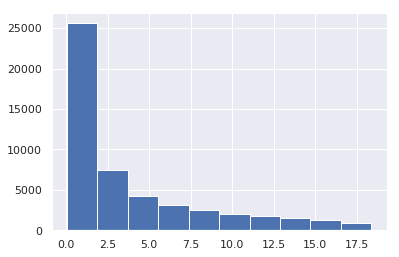

In [0]:
print(EnergyDeposit.shape)
EnergyDeposit_1d = EnergyDeposit.reshape(-1,900).mean(axis=1)
plt.hist(EnergyDeposit_1d)
plt.show()

In [0]:
# print(EnergyDeposit.shape)
# EnergyDeposit_1d = EnergyDeposit.reshape(-1,900).sum(axis=1)
# plt.hist(ParticleMomentum[:,2])
# plt.hist(ParticlePoint[:,0])
# plt.show()

## Load it to pytorch `DataLoader`

In [0]:
EnergyDeposit    = torch.tensor(EnergyDeposit).float()
ParticleMomentum = torch.tensor(ParticleMomentum).float()
ParticlePoint    = torch.tensor(ParticlePoint).float()
ParticlePDG      = torch.tensor(ParticlePDG).float()
# EnergyDeposit    = transforms.functional.normalize(EnergyDeposit,mean= (0.5,), std= (0.5,))
# ParticleMomentum = transforms.functional.normalize(ParticleMomentum,mean= (0.5,), std= (0.5,))
# ParticlePoint    = transforms.functional.normalize(ParticlePoint,mean= (0.5,), std= (0.5,))

calo_dataset = utils.TensorDataset(EnergyDeposit, ParticleMomentum, ParticlePoint, ParticlePDG)
calo_dataloader = torch.utils.data.DataLoader(calo_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)

In [0]:
for EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b, ParticlePDG_b in calo_dataloader:
    break

## Training GAN
###### ...is not a simple matter

It depends on architecture, loss, instance noise, augmentation and even luck(recommend to take a look https://arxiv.org/pdf/1801.04406.pdf)


In this notebook I have prepared some basic parts that you could use for your experiments.

In [0]:
TASKS = ['KL', 'REVERSED_KL', 'WASSERSTEIN', 'BAYESIAN']

TASK = 'BAYESIAN'
# TASK = 'WASSERSTEIN'

#### Small hack that can speed-up training and improve generalization

In [0]:
INSTANCE_NOISE = True

def add_instance_noise(data, std=0.01):
    return data + torch.distributions.Normal(0, std).sample(data.shape).to(device)

In [0]:
def LabelToImages(row,col,MomentumPoint):
    images = np.zeros((BATCH_SIZE,CONDITION_DIM,row,col))
    for image,mp in zip(images,MomentumPoint):
#         print(label.shape)
#         for cond in range(CONDITION_DIM):
        for i in range(CONDITION_DIM):
            image[i,:,:]+=mp[i].cpu().numpy()
#         print(image)
    return torch.Tensor(images)

In [0]:
class NoiseLoss(torch.nn.Module):
  # need the scale for noise standard deviation
  # scale = noise  std
    def __init__(self, params, noise_std, observed=None):
        super(NoiseLoss, self).__init__()
        self.observed = observed
        self.noise_std = noise_std

    def forward(self, params,  observed=None):
    # scale should be sqrt(2*alpha/eta)
    # where eta is the learning rate and alpha is the strength of drag term
        if observed is None:
            observed = self.observed

#         assert scale is not None, "Please provide scale"
        noise_loss = 0.0
        for var in params:
            # This is scale * z^T*v
            # The derivative wrt v will become scale*z
#             _noise = noise.normal_(0.,self.noise_std)
            _noise = self.noise_std*torch.randn(1)
            noise_loss += torch.sum(Variable(_noise.to(device))*var)
        noise_loss /= observed
        return noise_loss

class PriorLoss(torch.nn.Module):
  # negative log Gaussian prior
    def __init__(self, prior_std=1., observed=None):
        super(PriorLoss, self).__init__()
        self.observed = observed
        self.prior_std = prior_std

    def forward(self, params, observed=None):
        if observed is None:
            observed = self.observed
        prior_loss = 0.0
        for var in params:
            prior_loss += torch.sum(var*var/(self.prior_std*self.prior_std))
        prior_loss /= observed
        return prior_loss

In [0]:
# criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss()
# use the default index = 0 - equivalent to summing all other probabilities
# criterion_comp = ComplementCrossEntropyLoss(except_index=0)

In [0]:
sample_real = torch.zeros(10,1)
label_fake = torch.ones(10,1)
print(criterion(sample_real,label_fake).item())

27.631023406982422


## Defining discriminator

In [0]:
def normal_init(m, mean, std):
    if isinstance(m, (nn.Linear, nn.Conv2d, nn.BatchNorm2d, nn.BatchNorm1d)):
        m.weight.data.normal_(mean, std)
        if m.bias.data is not None:
            m.bias.data.zero_()

In [0]:
class ReducedConv(nn.Module):
    def __init__(self,input_size,output_size, input_dim, output_dim,kernel_size):
        super(ReducedConv, self).__init__()
        eps = 1e-3
        scale = float(output_dim+kernel_size-3+eps)/float(input_dim)
        self.ups = nn.Upsample(scale_factor = scale,mode = 'bilinear',align_corners=False )
        self.ref = nn.ReflectionPad2d(1)
        self.conv = nn.Conv2d(input_size,output_size,kernel_size)
    def forward(self,x):
        return self.conv(self.ref(self.ups(x)))
#         return self.ref(self.ups(x))

In [0]:
class ResidualBlock(nn.Module):
    def __init__(self,input_size):
        super(ResidualBlock, self).__init__()        
        self.conv1 = nn.Conv2d(input_size,input_size,3,padding=1)
        self.conv2 = nn.Conv2d(input_size,input_size,3,padding=1)
        self.bn1 = nn.BatchNorm2d(self.conv1.out_channels)
        self.bn2 = nn.BatchNorm2d(self.conv2.out_channels)        
    def forward(self,xraw):
        x = F.leaky_relu(self.bn1(self.conv1(xraw)))
        x = F.leaky_relu(self.bn2(self.conv2(x))+xraw)
        return x

In [0]:
class ModelD(nn.Module):
    def __init__(self):
        super(ModelD, self).__init__()
        self.conv1 = nn.Conv2d(1+CONDITION_DIM, 16, 4, stride=2)#30->14
        self.bn1 = nn.BatchNorm2d(16)
        self.dropout = nn.Dropout(p=0.2)
        self.conv2 = nn.Conv2d(16, 32, 4)##14->11
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 4)##11->8
        self.bn3 = nn.BatchNorm2d(64)        
        self.conv4 = nn.Conv2d(64, 128, 3)##8->6
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 1, 6)##6->4
        self.bn5 = nn.BatchNorm2d(256)
        self.resblock = ResidualBlock(128)
        
        # size
        self.fc1 = nn.Linear(256*4*4, 1) 
#         self.fc2 = nn.Linear(1024, 512)         
#         self.fc3 = nn.Linear(512, 128)
#         self.fc4 = nn.Linear(128, 64)
#         self.fc5 = nn.Linear(64, 1)
        
        self.bn_fc1 = nn.BatchNorm1d(1024)
        self.bn_fc2 = nn.BatchNorm1d(512)
        self.bn_fc3 = nn.BatchNorm1d(128)
        self.bn_fc4 = nn.BatchNorm1d(64)        
        
    def forward(self, EnergyDeposit, ParticleMomentum_ParticlePoint_ParticlePDG):
#         EnergyDeposit = NormalizeImage(EnergyDeposit_raw)
        EnergyDeposit = EnergyDeposit/EnergyDepositScale
        ParticleMomentum_ParticlePoint_ParticlePDG = torch.div(ParticleMomentum_ParticlePoint_ParticlePDG,MomentumPointPDGScale)
        LabelImages = LabelToImages(IMAGE_DIM,IMAGE_DIM,ParticleMomentum_ParticlePoint_ParticlePDG)
        EnergyDeposit = torch.cat([EnergyDeposit,LabelImages.cuda()],dim=1)
        EnergyDeposit = F.leaky_relu(self.conv1(EnergyDeposit))
        EnergyDeposut = self.dropout(EnergyDeposit)        
        EnergyDeposit = F.leaky_relu(self.bn2(self.conv2(EnergyDeposit)))
        EnergyDeposut = self.dropout(EnergyDeposit)
        EnergyDeposit = F.leaky_relu(self.bn3(self.conv3(EnergyDeposit)))
        EnergyDeposut = self.dropout(EnergyDeposit)
        EnergyDeposit = F.leaky_relu(self.bn4(self.conv4(EnergyDeposit)))
        EnergyDeposut = self.dropout(EnergyDeposit)
        # for ires in range(Nresblock):
        #     EnergyDeposit = self.dropout(self.resblock(EnergyDeposit))
        EnergyDeposit = self.conv5(EnergyDeposit) # 32, 9, 9
        EnergyDeposit = EnergyDeposit.view(EnergyDeposit.shape[0], -1)

        return torch.sigmoid(EnergyDeposit)
#         else:
#         return torch.sigmoid(self.fc5(t))
    def weight_init(self, mean, std):
            for m in self._modules:
                normal_init(self._modules[m], mean, std)


## Defining generator

In [0]:
class ModelGConvTranspose(nn.Module):
    def __init__(self, z_dim):
        self.z_dim = z_dim
        super(ModelGConvTranspose, self).__init__()
        self.fc1 = nn.Linear(self.z_dim + CONDITION_DIM, 256*4*4)
        self.resblock = ResidualBlock(16)
        self.resconv1 = ReducedConv(256,128,4,10,3)
        self.bn1 = nn.BatchNorm2d(128)
        self.resconv2 = ReducedConv(128,64,10,14,3)
        self.bn2 = nn.BatchNorm2d(64)
        self.resconv3 = ReducedConv(64,32,14,18,3)
        self.bn3 = nn.BatchNorm2d(32)
        self.resconv4 = ReducedConv(32,16,18,22,3)
        self.bn4 = nn.BatchNorm2d(16)        
        self.resconv5 = ReducedConv(16,8,22,26,3)
        self.bn5 = nn.BatchNorm2d(8)        
        self.resconv6 = ReducedConv(8,1,26,30,3)
        self.dropout = nn.Dropout(p=0.2)
        self.finout = nn.Tanh()
        
    def forward(self, z, ParticleMomentum_ParticlePoint_ParticlePDG):
#         ParticleMomentum_ParticlePoint = NormalizeMomentumPoint(ParticleMomentum_ParticlePoint)
        ParticleMomentum_ParticlePoint_ParticlePDG = torch.div(ParticleMomentum_ParticlePoint_ParticlePDG,MomentumPointPDGScale)
        x = F.leaky_relu(self.fc1(
            torch.cat([z, ParticleMomentum_ParticlePoint_ParticlePDG], dim=1)
        ))
#         x = F.leaky_relu(self.fc2(x))
#         x = F.leaky_relu(self.fc3(x))
#         x = F.leaky_relu(self.fc4(x))
        
        EnergyDeposit = x.view(-1, 256, 4, 4)
        
        EnergyDeposit = F.relu(self.bn1(self.resconv1(EnergyDeposit)))
        EnergyDeposit = F.relu(self.bn2(self.resconv2(EnergyDeposit)))
        EnergyDeposit = F.relu(self.bn3(self.resconv3(EnergyDeposit)))
        EnergyDeposit = F.relu(self.bn4(self.resconv4(EnergyDeposit)))
        EnergyDeposit = F.leaky_relu(self.bn5(self.resconv5(EnergyDeposit)))
#         for i in range(Nresblock):
#             EnergyDeposit = self.resblock(EnergyDeposit)

        EnergyDeposit = self.resconv6(EnergyDeposit)
        EnergyDeposit = torch.tanh(EnergyDeposit)
        EnergyDeposit = EnergyDeposit*EnergyDepositScale
#         EnergyDeposit = RescaleImage(EnergyDeposit)

        return EnergyDeposit

    def weight_init(self, mean, std):
            for m in self._modules:
                normal_init(self._modules[m], mean, std)

## Check our models on one batch 

In [0]:

gens = []
discs = []

gen = ModelGConvTranspose(z_dim=NOISE_DIM).to(device)
disc = ModelD().to(device)

gen.weight_init(mean=0.0, std=0.02)
disc.weight_init(mean=0.0, std=0.02)

In [0]:
# EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b = EnergyDeposit_b.to(device), \
#                                                        ParticleMomentum_b.to(device), \
#                                                        ParticlePoint_b.to(device)
# ParticleMomentum_ParticlePoint_b = torch.cat([ParticleMomentum_b.to(device), ParticlePoint_b.to(device)], dim=1)

In [0]:
# EnergyDeposit_b.shape

In [0]:
# disc(EnergyDeposit_b, ParticleMomentum_ParticlePoint_b).shape

In [0]:
# noise = torch.randn(len(EnergyDeposit_b), NOISE_DIM).to(device)
# gen(noise, ParticleMomentum_ParticlePoint_b).shape

In [0]:
gprior_criterion = PriorLoss(prior_std=1., observed=N)
gnoise_criterion = NoiseLoss(params=gen.parameters(), noise_std=math.sqrt(2 * gnoise_alpha * learning_rate), observed=N)
dprior_criterion = PriorLoss(prior_std=1., observed=N)
dnoise_criterion = NoiseLoss(params=disc.parameters(), noise_std=math.sqrt(2 * dnoise_alpha * learning_rate), observed=N)

## Defining optimiser

In [0]:
# learning_rate_dis = 1e-5
# learning_rate_gen = 1e-5
# gens_opt = []
# for gen in gens:
gen_opt = optim.Adam(gen.parameters(), lr=learning_rate, betas=(0.5, 0.999))
#     gens_opt.append(gen_opt)
# gen_opt = optim.Adam(gen.parameters(), lr=learning_rate, weight_decay=1e-6)
# g_optimizer = optim.RMSprop(discriminator.parameters(), lr=learning_rate_dis, weight_decay=1e-6)
# d_optimizer = optim.SGD(discriminator.parameters(), lr=learning_rate_dis, weight_decay=1e-6)
# d_optimizer = optim.RMSprop(discriminator.parameters(), lr=learning_rate_dis, weight_decay=1e-6)
# discs_opt = []
# for disc in discs:
disc_opt = optim.Adam(disc.parameters(), lr=learning_rate, betas=(0.5, 0.999))
# disc_opt = optim.SGD(disc.parameters(), lr=learning_rate)
#     discs_opt.append(disc_opt)

## Load scores

In [0]:
from prd_score import compute_prd, compute_prd_from_embedding, _prd_to_f_beta
from sklearn.metrics import auc

In [0]:
def D_train(EnergyDeposit_b,ParticleMomentum_ParticlePoint_ParticlePDG_b):
    #=======================Train the discriminator=======================#
    disc_opt.zero_grad()
    # ParticleMomentum_ParticlePoint_b = torch.cat([ParticleMomentum_b.to(device), ParticlePoint_b.to(device)], dim=1)
    noise = torch.randn(len(EnergyDeposit_b), NOISE_DIM).to(device)
    EnergyDeposit_gen = gen(noise, ParticleMomentum_ParticlePoint_ParticlePDG_b)

    if INSTANCE_NOISE:
        EnergyDeposit_b   = add_instance_noise(EnergyDeposit_b)
        EnergyDeposit_gen = add_instance_noise(EnergyDeposit_gen)
    output_real = disc(EnergyDeposit_b,ParticleMomentum_ParticlePoint_ParticlePDG_b)
    
#     labelv_real = Variable(.to(device))
#     real_label_noise = 0.1
    # labelv_real = Variable(torch.add(torch.ones(BATCH_SIZE, 1),real_label_noise,torch.rand(BATCH_SIZE, 1)).to(device))
    # labelv_real = Variable(torch.ones(len(EnergyDeposit_b), 1).to(device))
    labelv_real = Variable(0.9+0.1*torch.rand(len(EnergyDeposit_b), 1).to(device))
#     print(labelv_real)
    disc_real = criterion(output_real,labelv_real)
    disc_real.backward()
    output_fake = disc(EnergyDeposit_gen.detach(),ParticleMomentum_ParticlePoint_ParticlePDG_b)
#     fake_label_noise = 0.1
#     labelv_fake = Variable(torch.add(torch.zeros(BATCH_SIZE, 1),fake_label_noise,torch.rand(BATCH_SIZE, 1)).to(device))
    # labelv_fake = Variable(torch.zeros(len(EnergyDeposit_b), 1).to(device))
    labelv_fake = Variable(0.1*torch.rand(len(EnergyDeposit_b), 1).to(device)) 
#     print(labelv_fake)
    disc_fake = criterion(output_fake, labelv_fake)
    disc_fake.backward()

    disc_prior = dprior_criterion(disc.parameters())
    disc_prior.backward()
    disc_noise = dnoise_criterion(disc.parameters())
    disc_noise.backward()
    disc_loss = disc_real + disc_fake + disc_prior + disc_noise
#                 disc_loss = disc_real + disc_fake
#     disc_loss.backward()
    disc_opt.step()
        
    return  disc_loss.data.item(), disc_real.data.item(),disc_fake.data.item(),disc_prior.data.item(),disc_noise.data.item()

In [0]:
def G_train(EnergyDeposit_b,ParticleMomentum_ParticlePoint_ParticlePDG_b):
    #=======================Train the generator=======================#
    gen_opt.zero_grad()
    # ParticleMomentum_ParticlePoint_b = torch.cat([ParticleMomentum_b.to(device), ParticlePoint_b.to(device)], dim=1)
    noise = torch.randn(len(EnergyDeposit_b), NOISE_DIM).to(device)
    EnergyDeposit_gen = gen(noise, ParticleMomentum_ParticlePoint_ParticlePDG_b)
    if INSTANCE_NOISE:
        EnergyDeposit_b   = add_instance_noise(EnergyDeposit_b)
        EnergyDeposit_gen = add_instance_noise(EnergyDeposit_gen)
    output = disc(EnergyDeposit_gen,ParticleMomentum_ParticlePoint_ParticlePDG_b)
    labelv_real = Variable(torch.ones(BATCH_SIZE, 1).to(device))
    gen_real = criterion(output,labelv_real)
    gen_real.backward()
    gen_prior = gprior_criterion(gen.parameters())
    gen_prior.backward()
    gen_noise = gnoise_criterion(gen.parameters())    
    gen_noise.backward()    
    gen_loss = gen_real+gen_prior+gen_noise
#     gen_loss.backward()
    gen_opt.step()
        
    return gen_loss.data.item(),gen_real.data.item(),gen_prior.data.item(),gen_noise.data.item()

In [0]:

def run_training(epochs):
    ibatch = 0
    dis_epoch_loss = []
    gen_epoch_loss = []
    predictions_dis = []
    predictions_gen = []
    TotalEnergyDeposit_dis = []
    TotalEnergyDeposit_gen = []    
    prd_auc = []  
    for epoch in tqdm(range(epochs)):
        first = True
        
        for EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b, ParticlePDG_b in calo_dataloader:
            EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b, ParticlePDG_b = EnergyDeposit_b.to(device), \
                                                                   ParticleMomentum_b.to(device), \
                                                                   ParticlePoint_b.to(device), \
                                                                   ParticlePDG_b.to(device)

            # print(ParticleMomentum_b.shape, ParticlePoint_b.shape,ParticlePDG_b.shape)
            ParticlePDG_b = ParticlePDG_b.view(-1,1)
            ParticleMomentum_ParticlePoint_ParticlePDG_b = torch.cat([ParticleMomentum_b, ParticlePoint_b,ParticlePDG_b], dim=1)
            D_loss,D_real_loss,D_fake_loss,D_prior_loss,D_noise_loss = D_train(EnergyDeposit_b, ParticleMomentum_ParticlePoint_ParticlePDG_b)
            G_loss,G_real_loss,G_prior_loss,G_noise_loss             = G_train(EnergyDeposit_b, ParticleMomentum_ParticlePoint_ParticlePDG_b)
#             dis_epoch_loss.append(D_loss)
            experiment.log_metric("d_real", D_real_loss,step=ibatch)
            experiment.log_metric("d_fake", D_fake_loss,step=ibatch)
            experiment.log_metric("d_prior", D_prior_loss,step=ibatch)
            experiment.log_metric("d_noise", D_noise_loss,step=ibatch)
            experiment.log_metric("d_loss", D_loss,step=ibatch)
            experiment.log_metric("g_loss", G_loss,step=ibatch)
            experiment.log_metric("g_real_loss", G_real_loss,step=ibatch)
            experiment.log_metric("g_prior_loss", G_prior_loss,step=ibatch)
            experiment.log_metric("g_noise_loss", G_noise_loss,step=ibatch)
#             D_G_z1 = 
            noise = torch.randn(len(EnergyDeposit_b), NOISE_DIM).to(device)
            EnergyDeposit_gen = gen(noise, ParticleMomentum_ParticlePoint_ParticlePDG_b)
            predictions_dis.append(
                list(disc(EnergyDeposit_b, ParticleMomentum_ParticlePoint_ParticlePDG_b).data[:, 0].detach().cpu().numpy().ravel())
            )

            predictions_gen.append(
                list(disc(EnergyDeposit_gen, ParticleMomentum_ParticlePoint_ParticlePDG_b).data[:, 0].detach().cpu().numpy().ravel())
            )
            
#             TotalEnergyDeposit_dis.append(
#                 list(EnergyDeposit_b.sum(dim=1))
#             )
            
            if first:
                precision, recall = compute_prd_from_embedding(
                    EnergyDeposit_gen.detach().cpu().numpy().reshape(BATCH_SIZE, -1), 
                    EnergyDeposit_b.detach().cpu().numpy().reshape(BATCH_SIZE, -1),
                    num_clusters=30,
                    num_runs=100)
                prd_auc_ = auc(precision, recall)
                prd_auc.append(prd_auc_)
                experiment.log_metric("PRD_AUC", prd_auc_,step=epoch)                
#             if first:
                generator_cpu = ModelGConvTranspose(z_dim=NOISE_DIM)
                generator_cpu.load_state_dict(gen.state_dict())
#                 generator_cpu.eval()
                torch.save(generator_cpu.state_dict(), './gan%d.pt'%(epoch))
                first=False
            ibatch += 1
            clear_output()
            if ibatch %100 ==0:
                plt.figure(figsize=(15,12))
                grid = plt.GridSpec(2, 3, wspace=0.4, hspace=0.3)
                plt.subplot(grid[0,0])
#                 plt.semilogy(dis_epoch_loss, label='dis_epoch_loss')
#                 plt.semilogy(gen_epoch_loss, label='gen_epoch_loss')
#                 plt.legend()

                plt.subplot(grid[0,1])
        #         plt.xlim(-1,2)
                plt.hist(predictions_dis[-1], bins=40, label='dis_epoch_loss',color="blue",range=[0,1])
                plt.hist(predictions_gen[-1], bins=40, label='gen_epoch_loss',color="orange",range=[0,1])
                plt.legend()

                plt.subplot(grid[0,2])
                plt.plot(prd_auc, label='prd_auc')
                plt.ylim(0,1)
                plt.legend()
        #         plt.show()

                plt.subplot(grid[1, 0])
                plt.imshow(EnergyDeposit_gen[0][0].cpu().detach().numpy(),vmin=0)
                plt.subplot(grid[1, 1])
                plt.imshow(EnergyDeposit_gen[1][0].cpu().detach().numpy(),vmin=0)                
                plt.subplot(grid[1, 2])
                plt.imshow(EnergyDeposit_b[0][0].cpu().detach().numpy(),vmin=0)
                experiment.log_figure(figure=plt)
#             plt.show()



In [0]:
with experiment.train():
    run_training(N_EPOCH)

#### Transfer generator on CPU:

In [0]:
generator_cpu = ModelGConvTranspose(z_dim=NOISE_DIM)
# generator_cpu.load_state_dict(generator.state_dict())
generator_cpu.load_state_dict(torch.load('/content/gan21.pt'))
generator_cpu.eval()

### Save model on disk

In [0]:
torch.save(generator_cpu.state_dict(), './gan.pt')

## Making predictions

#### Validation predictions

In [0]:
data_val = np.load(val_data_path, allow_pickle=True)
ParticleMomentum_val = torch.tensor(data_val['ParticleMomentum']).float()
ParticlePoint_val = torch.tensor(data_val['ParticlePoint'][:, :2]).float()
ParticleMomentum_ParticlePoint_val = torch.cat([ParticleMomentum_val, ParticlePoint_val], dim=1)
calo_dataset_val = utils.TensorDataset(ParticleMomentum_ParticlePoint_val)
calo_dataloader_val = torch.utils.data.DataLoader(calo_dataset_val, batch_size=1024, shuffle=False)

with torch.no_grad():
    EnergyDeposit_val = []
    for ParticleMomentum_ParticlePoint_val_batch in tqdm(calo_dataloader_val):
        noise = torch.randn(len(ParticleMomentum_ParticlePoint_val_batch[0]), NOISE_DIM)
        EnergyDeposit_val_batch = generator_cpu(noise, ParticleMomentum_ParticlePoint_val_batch[0]).detach().numpy()
        EnergyDeposit_val.append(EnergyDeposit_val_batch)
    np.savez_compressed('./data_val_prediction.npz', 
                        EnergyDeposit=np.concatenate(EnergyDeposit_val, axis=0).reshape(-1, 30, 30))

    del EnergyDeposit_val
del data_val; del ParticleMomentum_val; del ParticlePoint_val; del ParticleMomentum_ParticlePoint_val;
del calo_dataset_val; calo_dataloader_val

#### Test predictions

In [0]:
data_test = np.load(test_data_path, allow_pickle=True)
ParticleMomentum_test = torch.tensor(data_test['ParticleMomentum']).float()
ParticlePoint_test = torch.tensor(data_test['ParticlePoint'][:, :2]).float()
ParticleMomentum_ParticlePoint_test = torch.cat([ParticleMomentum_test, ParticlePoint_test], dim=1)
calo_dataset_test = utils.TensorDataset(ParticleMomentum_ParticlePoint_test)
calo_dataloader_test = torch.utils.data.DataLoader(calo_dataset_test, batch_size=1024, shuffle=False)

with torch.no_grad():
    EnergyDeposit_test = []
    for ParticleMomentum_ParticlePoint_test_batch in tqdm(calo_dataloader_test):
        noise = torch.randn(len(ParticleMomentum_ParticlePoint_test_batch[0]), NOISE_DIM)
        EnergyDeposit_test_batch = generator_cpu(noise, ParticleMomentum_ParticlePoint_test_batch[0]).detach().numpy()
        EnergyDeposit_test.append(EnergyDeposit_test_batch)
    np.savez_compressed('./data_test_prediction.npz', 
                        EnergyDeposit=np.concatenate(EnergyDeposit_test, axis=0).reshape(-1, 30, 30))

    del EnergyDeposit_test
del data_test; del ParticleMomentum_test; del ParticlePoint_test; del ParticleMomentum_ParticlePoint_test;
del calo_dataset_test; calo_dataloader_test

## `zip-zip` files together

In [0]:
!zip solution.zip data_val_prediction.npz data_test_prediction.npz

In [0]:
from IPython.display import FileLink
FileLink('./solution.zip')

# A few words about metrics

### Lets generate some fake data

In [0]:
noise = torch.randn(len(ParticleMomentum_b), NOISE_DIM)
ParticleMomentum_ParticlePoint = torch.cat([ParticleMomentum, 
                                            ParticlePoint], dim=1)
EnergyDeposit_gen = generator_cpu(noise, ParticleMomentum_ParticlePoint_b.cpu())

In [0]:
EnergyDeposit_gen = EnergyDeposit_gen.detach().cpu().numpy().reshape(-1, 30, 30)
EnergyDeposit = EnergyDeposit.detach().cpu().numpy().reshape(-1, 30, 30)

#### Plot one image

In [0]:
plt.figure()
plt.imshow(EnergyDeposit_gen[0])
plt.colorbar()

## Calculate PRD score between these batch 

In [0]:
class Regressor(nn.Module):
    def __init__(self):
        super(Regressor, self).__init__()
        self.batchnorm0 = nn.BatchNorm2d(1)
        self.conv1 = nn.Conv2d(1, 16, 2, stride=2)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 2, stride=2)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 2, stride=2)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 2)
        
        self.dropout = nn.Dropout(p=0.3)
        
        self.fc1 = nn.Linear(256, 256) 
        self.batchnorm4 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 2 + 3)
        self.fc5 = nn.Linear(64, 1)
        
    def forward(self, x):
        x = self.batchnorm0(self.dropout(x))
        x = self.batchnorm1(self.dropout(F.relu(self.conv1(x))))
        x = self.batchnorm2(F.relu(self.conv2(x)))
        x = self.batchnorm3(F.relu(self.conv3(x)))
        x = F.relu(self.conv4(x)) # 64, 5, 5
        x = x.view(len(x), -1)
        x = self.dropout(x)
        x = self.batchnorm4(self.dropout(F.relu(self.fc1(x))))
        x = F.leaky_relu(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        return self.fc4(x), self.fc5(x)
    
    def get_encoding(self, x):
        x = self.batchnorm0(self.dropout(x))
        x = self.batchnorm1(self.dropout(F.relu(self.conv1(x))))
        x = self.batchnorm2(F.relu(self.conv2(x)))
        x = self.batchnorm3(F.relu(self.conv3(x)))
        x = F.relu(self.conv4(x)) # 64, 5, 5
        x = x.view(len(x), -1)
        x = self.dropout(x)
        x = self.batchnorm4(self.dropout(F.relu(self.fc1(x))))
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

def load_embedder(path):
    embedder = torch.load(path)
    embedder.eval()
    return embedder

embedder = load_embedder('./embedder.tp')

In [0]:
data_real = embedder.get_encoding(torch.tensor(EnergyDeposit).float().view(-1, 1, 30, 30)).detach().numpy()
data_fake = embedder.get_encoding(torch.tensor(EnergyDeposit_gen).float().view(-1, 1, 30, 30)).detach().numpy()

In [0]:
def plot_pr_aucs(precisions, recalls):
    plt.figure(figsize=(12, 12))
    pr_aucs = []
    for i in range(len(recalls)):
        plt.step(recalls[i], precisions[i], color='b', alpha=0.2,  label='PR-AUC={}'.format(auc(precisions[i], recalls[i])))
        pr_aucs.append(auc(precisions[i], recalls[i]))
    plt.step(np.mean(recalls, axis=0), np.mean(precisions, axis=0), color='r', alpha=1,  label='average')
    plt.fill_between(np.mean(recalls, axis=0), 
                     np.mean(precisions, axis=0) - np.std(precisions, axis=0) * 3,
                     np.mean(precisions, axis=0) + np.std(precisions, axis=0) * 3, color='g', alpha=0.2,  label='std')

    plt.xlabel('Recall')
    plt.ylabel('Precision')

    # plt.ylim([0.0, 1.05])
    # plt.xlim([0.0, 1.0])
    print(np.mean(pr_aucs), np.std(pr_aucs))
    plt.legend()
    
    return pr_aucs

def calc_pr_rec(data_real, data_fake, num_clusters=20, num_runs=10, NUM_RUNS=10):
    precisions = []
    recalls = []
    for i in tqdm(range(NUM_RUNS)):
        precision, recall = compute_prd_from_embedding(data_real, data_fake, num_clusters=num_clusters, num_runs=num_runs)
        precisions.append(precision)
        recalls.append(recall)
    return precisions, recalls

In [0]:
precisions, recalls = calc_pr_rec(data_real, data_fake, num_clusters=100, num_runs=20)

In [0]:
pr_aucs = plot_pr_aucs(precisions, recalls)
plt.title('Num_clusters={}, num_runs={}, first third'.format(100, 20))
plt.show()

In [0]:
pr_aucs

## Physical metrics

In [0]:
import matplotlib.lines as mlines
def newline(p1, p2):
    ax = plt.gca()
    xmin, xmax = ax.get_xbound()

    if(p2[0] == p1[0]):
        xmin = xmax = p1[0]
        ymin, ymax = ax.get_ybound()
    else:
        ymax = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmax-p1[0])
        ymin = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmin-p1[0])

    l = mlines.Line2D([xmin,xmax], [ymin,ymax])
    ax.add_line(l)
    return l

def plot_axes_for_shower(ecal, point, p):
    x = np.linspace(-14.5, 14.5, 30)
    y = np.linspace(-14.5, 14.5, 30)

    xx, yy = np.meshgrid(x, y)
    zoff = 25.
    ipic = 3
    orth = np.array([-p[1], p[0]])

    pref = point[:2] + p[:2] * zoff / p[2]

    p1 = pref - 10 * p[:2]
    p2 = pref + 10 * p[:2]
    p3 = pref - 10 * orth
    p4 = pref + 10 * orth

    plt.contourf(xx, yy, np.log(ecal + 1), cmap=plt.cm.inferno)
    newline(p1, p2)
    newline(p3, p4)
    plt.colorbar()

In [0]:
idx = 2
plot_axes_for_shower(EnergyDeposit[idx], point=ParticlePoint[idx].detach().numpy(),
                     p=ParticleMomentum[idx].detach().numpy())

In [0]:
from calogan_metrics import get_assymetry, get_shower_width, get_sparsity_level

In [0]:
assym = get_assymetry(EnergyDeposit, ParticleMomentum.detach().numpy(), ParticlePoint.detach().numpy(), orthog=False)
assym_ortho = get_assymetry(EnergyDeposit, ParticleMomentum.detach().numpy(), ParticlePoint.detach().numpy(), orthog=True)
sh_width = get_shower_width(EnergyDeposit, ParticleMomentum.detach().numpy(), ParticlePoint.detach().numpy(), orthog=False)
sh_width_ortho = get_shower_width(EnergyDeposit, ParticleMomentum.detach().numpy(), ParticlePoint.detach().numpy(), orthog=True)
sparsity_level = get_sparsity_level(EnergyDeposit)

## Longitudual cluster asymmetry

In [0]:
sns.set(font_scale=2)
plt.hist(assym, bins=50, range=[-1, 1], color='red', alpha=0.3, normed=True, label='MC');
plt.xlabel('Longitudual cluster asymmetry')
plt.legend(loc='best')

## Transverse cluster asymmetry

In [0]:
sns.set(font_scale=2)
plt.hist(assym_ortho, bins=50, range=[-1, 1], color='red', alpha=0.3, normed=True, label='MC');
plt.xlabel('Transverse cluster asymmetry')
plt.legend(loc='best')

## Cluster longitudual width

In [0]:
plt.hist(sh_width, bins=50, range=[0, 15], normed=True, alpha=0.3, color='red', label='MC');
plt.title('Shower longitudial width')
plt.legend(loc='best')
plt.xlabel('Cluster longitudual width [cm]')
plt.ylabel('Arbitrary units')

## Cluster trasverse width

In [0]:
plt.hist(sh_width_ortho, bins=50, range=[0,10], normed=True, alpha=0.3, color='blue', label='MC');
#plt.title('Shower transverse width')
plt.legend(loc='best')
plt.xlabel('Cluster trasverse width [cm]')
plt.ylabel('Arbitrary units')

## Sparsity

In [0]:
alphas = np.log(np.logspace(-5, -1, 20))
means_r = np.mean(sparsity_level, axis=1)
stddev_r = np.std(sparsity_level, axis=1)

In [0]:
plt.plot(alphas, means_r, color='red')
plt.fill_between(alphas, means_r-stddev_r, means_r+stddev_r, color='red', alpha=0.3)
plt.legend(['MC'])
plt.title('Sparsity')
plt.xlabel('log10(Threshold/GeV)')
plt.ylabel('Fraction of cells above threshold')

In [0]:
from calogan_metrics import get_physical_stats
real_phys_stats = get_physical_stats(EnergyDeposit, ParticleMomentum.detach().numpy(), ParticlePoint.detach().numpy())
gen_phys_stats = get_physical_stats(EnergyDeposit_gen, ParticleMomentum.detach().numpy(), ParticlePoint.detach().numpy())

In [0]:
precisions, recalls = calc_pr_rec(real_phys_stats, gen_phys_stats, num_clusters=100, num_runs=20)

In [0]:
pr_aucs = plot_pr_aucs(precisions, recalls)
plt.title('Num_clusters={}, num_runs={}, first third'.format(100, 20))
plt.show()

In [0]:
pr_aucs